In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768, 14548, 14590]

In [3]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    delta = mag-mag_fit
    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS

In [4]:
def makeTFandPLOT(ax, band = 'i', xLim = (1.4,3.1), yLim = (18.75,7.25)):

    table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                            filling_values=-1, names=True, dtype=None, encoding=None)

    addSouth=False
    if band in ['w1', 'w2']:
        addSouth=True
    
    Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
                                                addSouth=addSouth, pgcFaint=I_maglim)

    zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
    slope = zp_calibs['slope']
    zp    = zp_calibs['zp']
    zp_e = zp_calibs['zp_e']

#     Clusters = allCluster(table, band=band, slope=slope, pgcFaint=I_maglim)

    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    


    N_cluster = 0

    boolean = True
    for i, key in enumerate(Clusters):
            myCluster = Clusters[key]
            zp_ = myCluster['zp']
            I_mag = myCluster['mag']-zp_+zp
            logWimx = myCluster['logWimx']
            pgc =  myCluster['pgc']
            I_mag_w = myCluster['mag_w']-zp_+zp
            logWimx_w = myCluster['logWimx_w']    
            

            indx = []
            indx_ = []    
            for i, id in enumerate(pgc):
                if not id in I_maglim:
                    indx.append(i)
                else:
                    indx_.append(i)             

            if boolean:
                logWimx_=logWimx[indx]
                mag_=I_mag[indx]
                logWimx_e_=myCluster['logWimx_e'][indx]
                boolean = False
            else:                    
                logWimx_=np.concatenate((logWimx_, logWimx[indx]))
                mag_=np.concatenate((mag_, I_mag[indx]))
                logWimx_e_=np.concatenate((logWimx_e_, myCluster['logWimx_e'][indx]))               
                    
            alpha = 0.4
            if addSouth:
                alpha = 0.3
            
            ax.plot(logWimx[indx], I_mag[indx], '.', color=dye[band], alpha=alpha, 
                    ms=7, mec=dye[band])
            N_cluster += len(logWimx[indx])
            ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.3, markersize=5, markeredgecolor='none')        

            ax.plot(logWimx_w, I_mag_w, 'ko', alpha=0.3, 
                    ms=5, markeredgecolor='none')
            
            
    rms,RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, zp)
    print band, len(logWimx_), N_cluster, '%.2f'%slope0, '%.2f'%slope_e0, '%.2f'%rms, '%.2f'%RMS

    m0 = zp_calibs['slope']
    b0 = zp_calibs['zp']
    dm0 = zp_calibs['slope_e']
    db0 = zp_calibs['zp_e']
    mag_ = zp_calibs['MAG']
    logWimx_ = zp_calibs['logWimx']
    mag_e = zp_calibs['mag_e']
    logWimx_e = zp_calibs['logWimx_e']
    pgc = zp_calibs['pgc']



    indx = []
    indx_ = []    
    for i, id in enumerate(pgc):
        if not id in calib_maglim:
            indx.append(i)
        else:
            indx_.append(i)  




    ax.plot(logWimx_[indx], mag_[indx], 'o',  
                            markersize=5, color = 'k', mew=0.7)
    N_calib = len(logWimx_[indx])

    if len(indx_)>0:
                ax.plot(logWimx_[indx_], mag_[indx_], 'o',  
                        color='k', markersize=5, alpha=1., markerfacecolor='white')


    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+zp
    ax.plot(x,y, 'k-')  

    if band=='i':
        x = np.linspace(1.6,2.4,20)
        ax.plot(x,-17*x/x,'--', lw=1, color='navy')
        ax.text(2.45,-16.8, r'$M_{i^*}=-17$'+' mag', fontsize=11, color='navy')
    
#     if band=='u':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17+(2.68*(x-2.5)+1.58),'--', lw=1, color='navy')  
#     if band=='g':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17+(0.84*(x-2.5)+0.64),'--', lw=1, color='navy')  
#     if band=='r':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17+(0.27*(x-2.5)+0.23),'--', lw=1, color='navy')  
#     if band=='z':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17-(0.25*(x-2.5)+0.12),'--', lw=1, color='navy')          
    if band=='w1':
        x = np.linspace(1.6,2.4,20)
        ax.plot(x,-17-(1.18*(x-2.5)-0.47),'--', lw=1, color='navy')
#     if band=='w2':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17-(1.32*(x-2.5)-1.04),'--', lw=1, color='navy')        
    
        

    ax.text(2.2,-13, "%d" % N_cluster+' Cluster Galaxies', fontsize=12, color='k')
    ax.text(2.2,-12, "%d" % N_calib+' Zeropoint Galaxies', fontsize=12, color='k')
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(2.0, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(2.0, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14)     

            
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.95*Xlm[0]+0.05*Xlm[1]
    y0 = 0.2*Ylm[0]+0.80*Ylm[1]
    ax.text(x0,y0, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=12, color='k')
    y0 = 0.3*Ylm[0]+0.70*Ylm[1]
    ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % zp_e, fontsize=12, color='k')
    
    y0 = 0.1*Ylm[0]+0.9*Ylm[1]
    if addSouth:
        bandLab = band.upper()
    else:
        bandLab=band
    
    ax.text(x0,y0, "band: "+r'$'+bandLab+'$', fontsize=14, color='k')


u 440 440 -7.07 0.17 0.60 0.49
i 441 441 -8.37 0.13 0.49 0.40
w1 590 590 -9.47 0.14 0.58 0.52
g 441 441 -7.42 0.13 0.49 0.39
z 440 440 -8.49 0.13 0.50 0.40
w2 590 590 -9.65 0.15 0.62 0.54
r 441 441 -8.01 0.13 0.49 0.39


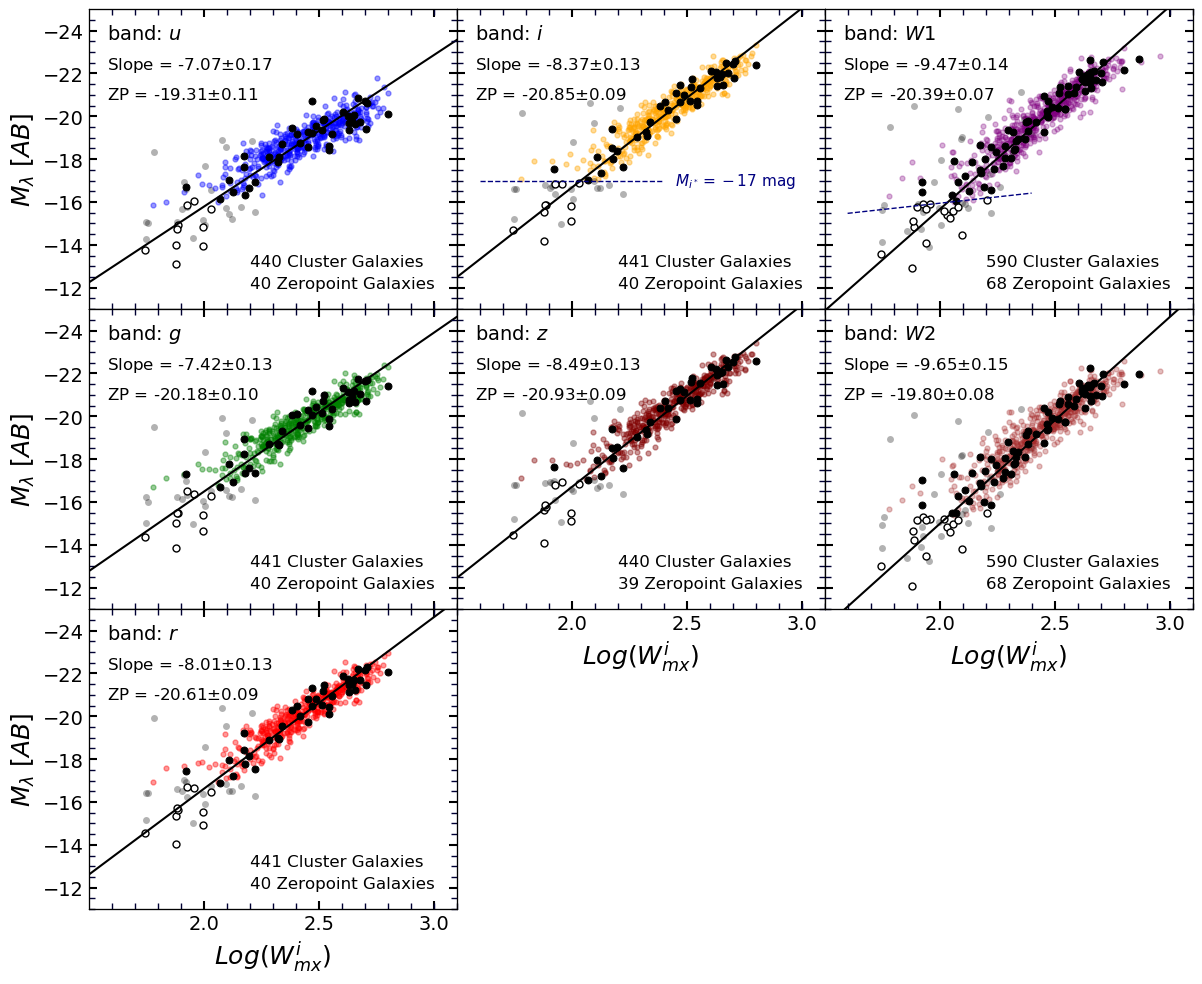

In [5]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0


ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'u', xLim = (1.5,3.1), yLim = (-11,-25))
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'i', xLim = (1.5,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'w1', xLim = (1.5,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)


ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'g', xLim = (1.5,3.1), yLim = (-11,-25))
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)


ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'z', xLim = (1.5,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'w2', xLim = (1.5,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'r', xLim = (1.5,3.1), yLim = (-11,-25))
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

plt.subplots_adjust(hspace=0, wspace=0)

In [6]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                            filling_values=-1, names=True, dtype=None, encoding=None)

In [26]:
allC = allCluster(table, band='i')

n1 = 0
n2 = 0
sdss_pgc = np.zeros(0)
for key in allC:
    
    n1 += len(allC[key]['pgc'])
    n2 += len(allC[key]['pgc_w'])
    
    sdss_pgc = np.concatenate((sdss_pgc, allC[key]['pgc_w']))
    sdss_pgc = np.concatenate((allC[key]['pgc'], sdss_pgc))
    
    
print n1, n2, n1+n2
print len(sdss_pgc)



456 8 464
464


In [27]:
allC = allCluster(table, band='w1')

n1 = 0
n2 = 0
wise_pgc = np.zeros(0)
for key in allC:
    
    n1 += len(allC[key]['pgc'])
    n2 += len(allC[key]['pgc_w'])
    wise_pgc = np.concatenate((wise_pgc, allC[key]['pgc_w']))
    wise_pgc = np.concatenate((allC[key]['pgc'], wise_pgc))
    
    
print n1, n2, n1+n2
print len(wise_pgc)

602 19 621
621


In [28]:
456 8 464
In [13]:

602 19 621
In [ ]:


SyntaxError: invalid syntax (<ipython-input-28-641e30dc35b7>, line 1)

In [ ]:
grand_pgc = []

for idd in wise_pgc:
    if not idd in grand_pgc:
        grand_pgc.append(idd)
        

for idd in sdss_pgc:
    if not idd in grand_pgc:
        grand_pgc.append(idd)

print len(grand_pgc)      

In [29]:
m = 0 
for idd in wise_pgc:
     if idd in sdss_pgc:
            m+=1
print m

435
